### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.neighbors import NearestNeighbors

### Load and prechecks

In [2]:
countries_df = pd.read_csv("data/countries.csv", index_col=0)

countries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [3]:
descending_feats = ["child_mort", "inflation"]
ascending_feats = ["life_expec", "gdpp", "income", "imports", "health", "exports"]
neutral_feats = ["total_fer"]

### Corrplot

In [4]:
# make a function from the code below

def plot_corr(df):
    """
    This function plots a correlation matrix for a dataframe
    
    """
    corr_matrix = df.corr()

    # Convert the correlation matrix into a tidy format
    corr_matrix = corr_matrix.stack().reset_index()
    corr_matrix.columns = ["feature_1", "feature_2", "correlation"]

    # Create the feature corrplot
    base = alt.Chart(corr_matrix).encode(
        x="feature_1:N",
        y="feature_2:N"
    )

    # Add the rectangles
    rects = base.mark_rect().encode(
        color=alt.Color("correlation:Q")
    )

    # Add the text labels
    labels = base.mark_text(baseline="middle").encode(
        text=alt.Text("correlation:Q", format=".2f"),
        color=alt.condition(
            alt.datum.correlation > 0.5,
            alt.value("white"),
            alt.value("black")
        )
    )

    # Show only half of the matrix
    corr_plot = (rects + labels).properties(
        width=400,
        height=400
    ).transform_filter(
        alt.datum.feature_1 < alt.datum.feature_2
    )
    return corr_plot

plot_corr(countries_df)

alt.LayerChart(...)

### Extremal countries:

In [5]:
def plot_extrema(df, feature):
    lowest = df.sort_values(feature).head(10)
    highest = df.sort_values(feature, ascending=False).head(10)
    
    # Create bar plots for lowest and highest values
    lowest_plot = alt.Chart(lowest).mark_bar().encode(
        x=alt.X('country:N', title=None),
        y=alt.Y(f'{feature}:Q', title=feature),
        color=alt.Color(f'{feature}:Q', scale=alt.Scale(scheme='redyellowblue'))
    ).properties(
        width=400,
        height=250
    )

    highest_plot = alt.Chart(highest).mark_bar().encode(
        x=alt.X('country:N', title=None),
        y=alt.Y(f'{feature}:Q', title=feature),
        color=alt.Color(f'{feature}:Q', scale=alt.Scale(scheme='redyellowblue'))
    ).properties(
        width=400,
        height=250
    )

    # Combine the plots and adjust axis properties
    combined_plots = alt.hconcat(lowest_plot, highest_plot)
    combined_plots.configure_axis(labelAngle=90).configure_view(stroke=None)

    # Show the plot
    return combined_plots

plot_extrema(countries_df.reset_index(), 'income')

alt.HConcatChart(...)

### Features distribution

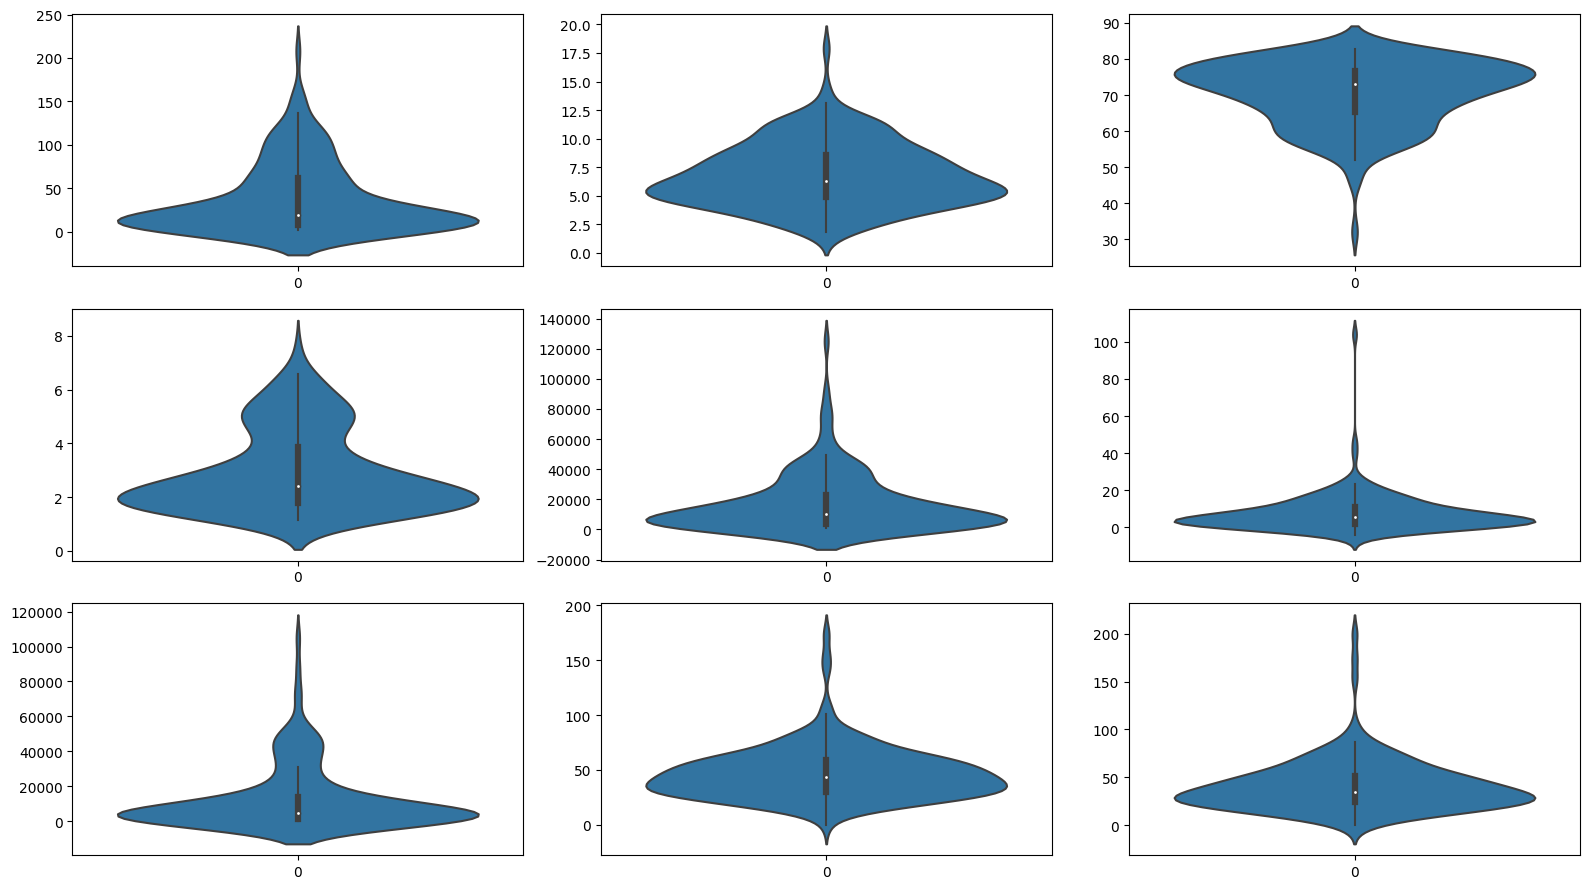

In [6]:
fig, axs = plt.subplots(3,3, figsize = (16, 9))
plt1 = sns.violinplot(countries_df['child_mort'], ax = axs[0,0])
plt2 = sns.violinplot(countries_df['health'], ax = axs[0,1])
plt3 = sns.violinplot(countries_df['life_expec'], ax = axs[0,2])
plt4 = sns.violinplot(countries_df['total_fer'], ax = axs[1,0])
plt5 = sns.violinplot(countries_df['income'], ax = axs[1,1])
plt6 = sns.violinplot(countries_df['inflation'], ax = axs[1,2])
plt7 = sns.violinplot(countries_df['gdpp'], ax = axs[2,0])
plt8 = sns.violinplot(countries_df['imports'], ax = axs[2,1])
plt9 = sns.violinplot(countries_df['exports'], ax = axs[2,2])


plt.tight_layout()

In [8]:
def test_hopkins(X: pd.DataFrame, sample_size: int = None) -> float:
    """
    Calculates the Hopkins statistic for the input DataFrame:
        If the value is between (0.01, ...,0.3), the data is regularly spaced.

        If the value is around 0.5, it is random.

        If the value is between (0.7, ..., 0.99), it has a high tendency to cluster.
        
    Parameters:
        X (pd.DataFrame): The input DataFrame of shape (n_samples, n_features).
        sample_size (int): The size of the random sample to use. Defaults to 10% of the input size.

    Returns:
        The Hopkins statistic for the input DataFrame.
    """

    if sample_size is None:
        sample_size = int(0.25 * len(X))

    nbrs = NearestNeighbors(n_neighbors=1,
                            algorithm='brute',
                            metric='euclidean')
    nbrs.fit(X.values)
    
    rand_X = np.random.choice(len(X), sample_size, replace=False)

    ujd = []
    wjd = []
    for j in rand_X:
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X.values, axis=0),
                                                      np.amax(X.values, axis=0),
                                                      size=X.shape[1]).reshape(1, -1),
                                    2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.values[j].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    h = sum(ujd) / (sum(ujd) + sum(wjd))
    if np.isnan(h):
        print(ujd, wjd)
        h = 0

    return h

# the data
test_hopkins(countries_df)

0.9421745854989116